In [1]:
import itertools
import pandas
import numpy

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer, OrdinalEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_log_error, mean_squared_error, make_scorer

import seaborn
import matplotlib
import matplotlib.pyplot as plt

### Context

In this notebook we construct a feature preprocessing pipeline and evaluate a few different regression models.

## 0 Load data and split

In [2]:
df = (
    pandas.read_csv("../data/raw/train.csv")
    .loc[lambda x: ~x["Id"].isin([524, 1299])]
    .set_index(keys=["Id"])
)

In [3]:
target = "SalePrice"
features = [col for col in df.columns if col != target]

Let's split into train/test so we have a hold out set for later

In [4]:
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

## 1 Feature preprocessing

Create transformations for feature preprocessing and engineering, this boils down to:

* Add some custom features
* Impute missing values
    * For some categoricals we impute with a new category
    * For some categoricals we impute with the mode
    * For some numericals we impute with zero
    * For the column "Functional" we impute with "Typ"
* Encode categoricals as ordinals
    * I.e., create a mapping from categorical values to an integer
* Perform power transformations on non-normally distributed continuous variables

We define a number of pipelines to handle the different cases, then combine them using a `ColumnTransformer`


### Define some new features

In [5]:
def add_boolean_features(df):
    return (
        df
        .assign(
            HasPool=lambda x: numpy.where(x["PoolArea"] > 0, 1, 0),
            Has2ndFloor=lambda x: numpy.where(x["2ndFlrSF"] > 0, 1, 0),
            HasGarage=lambda x: numpy.where(x["GarageArea"] > 0, 1, 0),
            HasBasement=lambda x: numpy.where(x["TotalBsmtSF"] > 0, 1, 0),
            HasFireplace=lambda x: numpy.where(x["Fireplaces"] > 0, 1, 0),
            HasBeenRemodelled=lambda x: numpy.where(x["YearBuilt"] == x["YearRemodAdd"], 1, 0),
        )
    )

def add_boolean_feature_names(self, input_features):
    return numpy.hstack([
        input_features,
        ["HasPool", "Has2ndFloor", "HasGarage", "HasBasement", "HasFireplace", "HasBeenRemodelled"]
    ])

In [6]:
transformer_add_boolean_features = FunctionTransformer(
    add_boolean_features,
    feature_names_out=add_boolean_feature_names,
)

In [7]:
transformer_add_boolean_features.fit_transform(X).loc[lambda x: x["HasPool"] == 1]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,MoSold,YrSold,SaleType,SaleCondition,HasPool,Has2ndFloor,HasGarage,HasBasement,HasFireplace,HasBeenRemodelled
Id,,,,,,,,,,,,,,,,,,,,,
198,75,RL,174.0,25419,Pave,NaN,Reg,Lvl,AllPub,Corner,...,3,2006,WD,Abnorml,1,1,1,1,1,0
811,20,RL,78.0,10140,Pave,NaN,Reg,Lvl,AllPub,Inside,...,1,2006,WD,Normal,1,0,1,1,1,0
1171,80,RL,76.0,9880,Pave,NaN,Reg,Lvl,AllPub,Inside,...,7,2008,WD,Normal,1,0,1,1,1,1
1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,Corner,...,7,2007,WD,Abnorml,1,1,1,1,1,1
1387,60,RL,80.0,16692,Pave,NaN,IR1,Lvl,AllPub,Inside,...,7,2006,WD,Normal,1,1,1,1,1,1
1424,80,RL,NaN,19690,Pave,NaN,IR1,Lvl,AllPub,CulDSac,...,8,2006,WD,Alloca,1,1,1,1,1,1


In [8]:
def add_total_sf_features(df):
    return (
        df
        .assign(
            TotalSF=lambda x: x["TotalBsmtSF"] + x["1stFlrSF"] + x["2ndFlrSF"],
            TotalBathrooms=lambda x: x["FullBath"] + 0.5 * x["HalfBath"] + x["BsmtFullBath"] + 0.5 * x["BsmtHalfBath"],
            TotalPorchSF=lambda x: x["OpenPorchSF"] + x["3SsnPorch"] + x["EnclosedPorch"] + x["ScreenPorch"] + x["WoodDeckSF"],
            BuildingAge=lambda x: x["YrSold"] - x["YearRemodAdd"],
        )
    )

def add_total_sf_feature_names(self, input_features):
    return numpy.hstack([
        input_features,
        ["TotalSF", "TotalBathrooms", "TotalPorchSF", "BuildingAge"]
    ])

In [9]:
transformer_add_total_features = FunctionTransformer(
    add_total_sf_features,
    feature_names_out=add_total_sf_feature_names
)

In [10]:
transformer_add_total_features.fit_transform(X_train).head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,TotalSF,TotalBathrooms,TotalPorchSF,BuildingAge
Id,,,,,,,,,,,,,,,,,,,,,
69,30,RM,47.0,4608,Pave,NaN,Reg,Lvl,AllPub,Corner,...,NaN,0,6,2010,WD,Normal,1494,1.0,0,60
1069,160,RM,42.0,3964,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,0,6,2006,WD,Normal,3463,3.5,748,33
1438,20,RL,96.0,12444,Pave,NaN,Reg,Lvl,AllPub,FR2,...,NaN,0,11,2008,New,Partial,3864,3.0,370,0
716,20,RL,78.0,10140,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,0,8,2009,WD,Normal,2414,2.0,0,35
795,60,RL,NaN,10832,Pave,NaN,IR1,Lvl,AllPub,Corner,...,Shed,500,10,2008,WD,Normal,2607,2.5,189,12


In [11]:
def add_neighborhood_features(df):

    nghd_scores = (
        df
        .groupby(by=["Neighborhood"])
        .agg({"OverallQual": "mean"})
        .sort_values(by=["OverallQual"], ascending=False)
    )

    return (
        df
        .assign(
            NeighborhoodQual=lambda x: numpy.select(
                [x["Neighborhood"].isin(nghd_scores.head(3).index), x["Neighborhood"].isin(nghd_scores.tail(3).index)],
                ["High", "Low"],
                default="Mid"
            )
        )
    )

In [12]:
def add_neighborhood_feature_names(self, input_features):
    return numpy.hstack([
        input_features,
        ["NeighborhoodQual"]
    ])

In [13]:
transformer_add_neighborhood_features = FunctionTransformer(
    add_neighborhood_features,
    feature_names_out=add_neighborhood_feature_names
)

### Handle Ordinal Categoricals

A large number of features are categoricals that we encode as ordinals. We impute missing values as a new "None" category.

In [14]:
ordinal_categorical_pipe = Pipeline(steps=[
    ("impute_missing_categoricals", SimpleImputer(strategy="constant", fill_value="None")),
    ("encode_ordinal_values", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

In [15]:
ordinal_categorical_features = [
    "PoolQC",
    "MiscFeature",
    "Alley",
    "Fence",
    "FireplaceQu",
    "GarageType",
    "GarageFinish",
    "GarageCond",
    "BsmtCond",
    "BsmtExposure",
    "BsmtFinType1",
    "BsmtFinType2",
    "MasVnrType",
    "MSSubClass",
    "Functional",
    "CentralAir",
    "ExterCond",
    "HeatingQC",
    "LandSlope",
    "LotShape",
    "OverallCond",
    "PavedDrive",
    "Street",
    "KitchenAbvGr",
    "Foundation",
    "SaleCondition",
    "RoofStyle",
    "HouseStyle",
    "Neighborhood",
    "RoofMatl",
    "LotConfig",
    "Condition1",
    "Condition2",
    "BldgType",
    "LandContour",
    "NeighborhoodQual",
]

For some categoricals, it makes more sense to impute with the most common value (mode).

In [16]:
ordinal_categorical_with_mode_imputed_pipe = Pipeline(steps=[
    ("impute_missing_categoricals_as_mode", SimpleImputer(strategy="most_frequent")),
    ("encode_ordinal_values", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

In [17]:
ordinal_categorical_with_mode_imputed_features = [
    "MSZoning",
    "Utilities",
    "Electrical",
    "Heating",
    "KitchenQual",
    "GarageQual",
    "BsmtQual",
    "ExterQual",
    "Exterior1st",
    "Exterior2nd",
    "SaleType"
]

### Handle date-related features

We cast these dates as ordinals.

In [18]:
date_transformation_pipe = Pipeline(steps=[
    ("impute_missing_categoricals", SimpleImputer(strategy="constant", fill_value=-1)),
    ("encode_ordinal_values", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

In [19]:
date_features = [
    "YrSold",
    "MoSold",
    "YearBuilt",
    "YearRemodAdd",
    "GarageYrBlt",
    "BuildingAge",
]

### Handle Numerical Values with Zero Imputed

In [20]:
numerical_values_cast_as_ordinals_pipe = Pipeline(steps=[
    ("impute_zero", SimpleImputer(strategy="constant", fill_value=0)),
    ("encode_ordinal_values", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

In [21]:
numerical_ordinals_features = [
    "GarageCars",
    "BsmtFullBath",
    "BsmtHalfBath",
    "BedroomAbvGr",
    "Fireplaces",
    "FullBath",
    "HalfBath",
    "OverallQual",
    "TotRmsAbvGrd",
    "TotalBathrooms",
    # Booleans
    "HasPool",
    "Has2ndFloor",
    "HasGarage",
    "HasBasement",
    "HasFireplace",
    "HasBeenRemodelled",
]

### Handle Power Transformations

Some continuous variables are not normally distributed, we can apply a power transformation to help.

In [22]:
power_transformation_pipe = Pipeline(steps=[
    ("impute_zero", SimpleImputer(strategy="constant", fill_value=0)),
    ("power_transform", PowerTransformer()),
])

In [23]:
power_transform_features = [
    "MiscVal",
    "PoolArea",
    "LotArea",
    "LowQualFinSF",
    "3SsnPorch",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "TotalBsmtSF",
    "EnclosedPorch",
    "ScreenPorch",
    "MasVnrArea",
    "1stFlrSF",
    "2ndFlrSF",
    "GrLivArea",
    "OpenPorchSF",
    "WoodDeckSF",
    "LotFrontage",
    "GarageArea",
    "TotalSF",
    "TotalPorchSF",
]

### Check for overlap in lists

In [24]:
lists = [
    ordinal_categorical_features,
    ordinal_categorical_with_mode_imputed_features,
    numerical_ordinals_features,
    date_features,
    power_transform_features,
]

In [25]:

for a, b in itertools.combinations(lists, 2):
    print(set(a).intersection(set(b)))

set()
set()
set()
set()
set()
set()
set()
set()
set()
set()


### Combine preprocessing in ColumnTransformer

In [26]:
preprocessing_pipe = Pipeline(
    steps=[
        ("add_boolean_features", transformer_add_boolean_features),
        ("add_total_features", transformer_add_total_features),
        ("add_neighborhood_features", transformer_add_neighborhood_features),
        (
            "preprocess_features",
            ColumnTransformer([
                (
                    "ordinal_categoricals_with_category_imputed",
                    ordinal_categorical_pipe,
                    ordinal_categorical_features
                ),
                (
                    "ordinal_categoricals_with_mode_imputed",
                    ordinal_categorical_with_mode_imputed_pipe,
                    ordinal_categorical_with_mode_imputed_features
                ),
                (
                    "numericals_as_ordinals",
                    numerical_values_cast_as_ordinals_pipe,
                    numerical_ordinals_features
                ),
                (
                    "date_transformations",
                    date_transformation_pipe,
                    date_features,
                ),
                (
                    "non_normal_continuous_variables",
                    power_transformation_pipe,
                    power_transform_features
                ),
            ], remainder="drop")
        ),
    ]
)

In [27]:
preprocessing_pipe

Pipeline(steps=[('add_boolean_features',
                 FunctionTransformer(feature_names_out=<function add_boolean_feature_names at 0x000001446B84FE20>,
                                     func=<function add_boolean_features at 0x000001446B84FD80>)),
                ('add_total_features',
                 FunctionTransformer(feature_names_out=<function add_total_sf_feature_names at 0x0000014476ED2D40>,
                                     func=<function add_total_sf_features at 0x00...
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('power_transform',
                                                                   PowerTransformer())]),
                                                  ['MiscVal', 'PoolArea',
                                                   'LotArea', 'LowQualFinSF',
                                                   '3SsnPorch', 'BsmtFinSF1',
                                                   'BsmtFinSF2', 'BsmtUnfSF',
                                                   'TotalBsmtSF',
                                                   'EnclosedPorch',
                                                   'ScreenPorch', 'MasVnrArea',
                                                   '1stFlrSF', '2ndFlrSF',
                                                   'GrLivArea', 'OpenPorchSF',
                                                   'WoodDeckSF', 'LotFrontage',
                                                   'GarageArea', 'TotalSF',
                                                   'TotalPorchSF'])]))])

In [28]:
out = preprocessing_pipe.fit_transform(df)

In [29]:
df_transformed = pandas.DataFrame(out, columns=preprocessing_pipe.get_feature_names_out())

In [30]:
df_transformed.head()

,ordinal_categoricals_with_category_imputed__PoolQC,ordinal_categoricals_with_category_imputed__MiscFeature,ordinal_categoricals_with_category_imputed__Alley,ordinal_categoricals_with_category_imputed__Fence,ordinal_categoricals_with_category_imputed__FireplaceQu,ordinal_categoricals_with_category_imputed__GarageType,ordinal_categoricals_with_category_imputed__GarageFinish,ordinal_categoricals_with_category_imputed__GarageCond,ordinal_categoricals_with_category_imputed__BsmtCond,ordinal_categoricals_with_category_imputed__BsmtExposure,...,non_normal_continuous_variables__MasVnrArea,non_normal_continuous_variables__1stFlrSF,non_normal_continuous_variables__2ndFlrSF,non_normal_continuous_variables__GrLivArea,non_normal_continuous_variables__OpenPorchSF,non_normal_continuous_variables__WoodDeckSF,non_normal_continuous_variables__LotFrontage,non_normal_continuous_variables__GarageArea,non_normal_continuous_variables__TotalSF,non_normal_continuous_variables__TotalPorchSF
0,3.0,1.0,1.0,4.0,3.0,1.0,2.0,5.0,4.0,3.0,...,1.233710,-0.806074,1.172248,0.531667,0.845196,-0.949026,0.297149,0.388861,0.108324,-0.519214
1,3.0,1.0,1.0,4.0,5.0,1.0,2.0,5.0,4.0,1.0,...,-0.817134,0.429219,-0.870086,-0.390289,-1.070360,1.214767,0.671819,-0.002790,0.053519,0.831211
2,3.0,1.0,1.0,4.0,5.0,1.0,2.0,5.0,4.0,2.0,...,1.197063,-0.576380,1.174891,0.665249,0.671672,-0.949026,0.373596,0.649275,0.286946,-0.724393
3,3.0,1.0,1.0,4.0,2.0,5.0,3.0,5.0,1.0,3.0,...,-0.817134,-0.437537,1.148963,0.544199,0.587679,-0.949026,0.167844,0.794747,-0.013825,0.866247
4,3.0,1.0,1.0,4.0,5.0,1.0,2.0,5.0,4.0,0.0,...,1.335443,0.119914,1.211427,1.308515,0.995396,1.081348,0.768805,1.600339,1.032239,0.742912


## Estimators

Create helper method to insert estimator within model pipeline

In [31]:
def make_pipeline(estimator):

    return Pipeline(steps=[
        ("add_boolean_features", transformer_add_boolean_features),
        ("add_total_features", transformer_add_total_features),
        ("add_neighborhood_features", transformer_add_neighborhood_features),
        (
            "preprocess_features",
            ColumnTransformer([
                (
                    "ordinal_categoricals_with_category_imputed",
                    ordinal_categorical_pipe,
                    ordinal_categorical_features
                ),
                (
                    "ordinal_categoricals_with_mode_imputed",
                    ordinal_categorical_with_mode_imputed_pipe,
                    ordinal_categorical_with_mode_imputed_features
                ),
                (
                    "numericals_as_ordinals",
                    numerical_values_cast_as_ordinals_pipe,
                    numerical_ordinals_features
                ),
                (
                    "date_transformations",
                    date_transformation_pipe,
                    date_features,
                ),
                (
                    "non_normal_continuous_variables",
                    power_transformation_pipe,
                    power_transform_features
                ),
            ], remainder="drop")
        ),
        ("regressor", TransformedTargetRegressor(
            regressor=estimator,
            transformer=PowerTransformer())
        )
    ])   

### Random Forest Regressor

Let's use a random forest regressor as a starting point

In [32]:
pipe_rfr = make_pipeline(RandomForestRegressor(n_estimators=100))

In [33]:
pipe_rfr

Pipeline(steps=[('add_boolean_features',
                 FunctionTransformer(feature_names_out=<function add_boolean_feature_names at 0x000001446B84FE20>,
                                     func=<function add_boolean_features at 0x000001446B84FD80>)),
                ('add_total_features',
                 FunctionTransformer(feature_names_out=<function add_total_sf_feature_names at 0x0000014476ED2D40>,
                                     func=<function add_total_sf_features at 0x00...
                                                   'LotArea', 'LowQualFinSF',
                                                   '3SsnPorch', 'BsmtFinSF1',
                                                   'BsmtFinSF2', 'BsmtUnfSF',
                                                   'TotalBsmtSF',
                                                   'EnclosedPorch',
                                                   'ScreenPorch', 'MasVnrArea',
                                                   '1stFlrSF', '2ndFlrSF',
                                                   'GrLivArea', 'OpenPorchSF',
                                                   'WoodDeckSF', 'LotFrontage',
                                                   'GarageArea', 'TotalSF',
                                                   'TotalPorchSF'])])),
                ('regressor',
                 TransformedTargetRegressor(regressor=RandomForestRegressor(),
                                            transformer=PowerTransformer()))])

Evaluate model

In [34]:
score_function = make_scorer(mean_squared_log_error, greater_is_better=False)

In [35]:
scores = numpy.sqrt(-cross_val_score(pipe_rfr, X_train, y_train, cv=5, scoring=score_function))

In [36]:
scores

array([0.11216294, 0.11770815, 0.14796406, 0.15756142, 0.14876811])

Train on full training set to examine feature importances

In [37]:
pipe_rfr.fit(X_train, y_train)

Pipeline(steps=[('add_boolean_features',
                 FunctionTransformer(feature_names_out=<function add_boolean_feature_names at 0x000001446B84FE20>,
                                     func=<function add_boolean_features at 0x000001446B84FD80>)),
                ('add_total_features',
                 FunctionTransformer(feature_names_out=<function add_total_sf_feature_names at 0x0000014476ED2D40>,
                                     func=<function add_total_sf_features at 0x00...
                                                   'LotArea', 'LowQualFinSF',
                                                   '3SsnPorch', 'BsmtFinSF1',
                                                   'BsmtFinSF2', 'BsmtUnfSF',
                                                   'TotalBsmtSF',
                                                   'EnclosedPorch',
                                                   'ScreenPorch', 'MasVnrArea',
                                                   '1stFlrSF', '2ndFlrSF',
                                                   'GrLivArea', 'OpenPorchSF',
                                                   'WoodDeckSF', 'LotFrontage',
                                                   'GarageArea', 'TotalSF',
                                                   'TotalPorchSF'])])),
                ('regressor',
                 TransformedTargetRegressor(regressor=RandomForestRegressor(),
                                            transformer=PowerTransformer()))])

### Feature Importance - Impurity

In [38]:
df_feature_importances_i = pandas.Series(
    data=pipe_rfr.steps[-1][-1].regressor_.feature_importances_,
    index=pipe_rfr.steps[-2][1].get_feature_names_out(),
)

<Axes: >

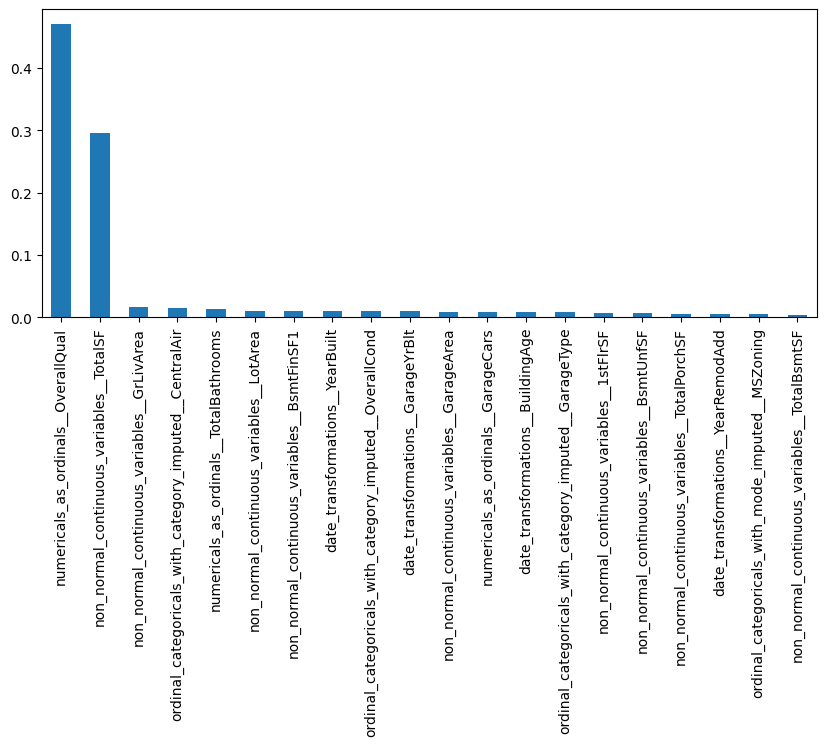

In [39]:
f, ax = plt.subplots(1, 1, figsize=(10, 4))

df_feature_importances_i.sort_values(ascending=False).head(20).plot(kind='bar', ax=ax)

### Feature importance - Permutation

In [40]:
r = permutation_importance(pipe_rfr, X_train, y_train, n_repeats=8, random_state=123)

In [41]:
r["importances_mean"].shape

(79,)

In [43]:
df_feature_importances_p = pandas.Series(
    data=r["importances_mean"],
    index=pipe_rfr.steps[0][1].feature_names_in_
)

<Axes: >

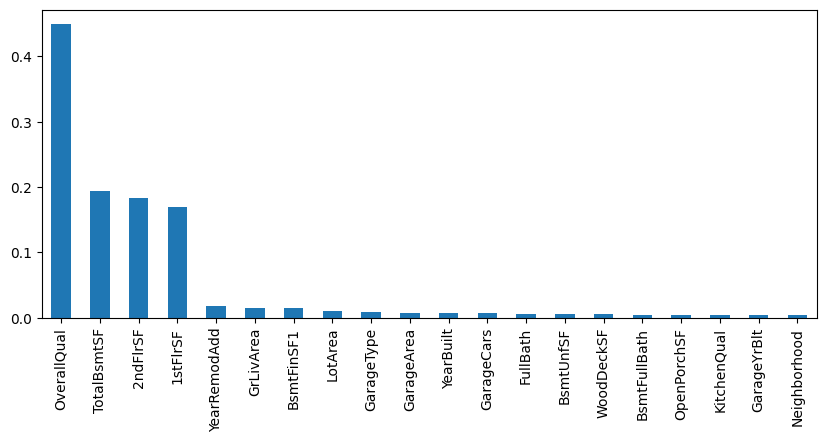

In [44]:
f, ax = plt.subplots(1, 1, figsize=(10, 4))

df_feature_importances_p.sort_values(ascending=False).head(20).plot(kind='bar', ax=ax)

## Grid Searches

### Random Forest Regressor

In [45]:
pipe_rfr = make_pipeline(RandomForestRegressor())

params = {
    "regressor__regressor__n_estimators": [64, 128, 252, 512],
    "regressor__regressor__min_samples_leaf": [2, 4, 8],
    "regressor__regressor__min_samples_split": [8, 16, 32],
}

gs = GridSearchCV(pipe_rfr, param_grid=params, scoring=score_function, n_jobs=4, verbose=2).fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [46]:
gs.best_params_

{'regressor__regressor__min_samples_leaf': 2,
 'regressor__regressor__min_samples_split': 8,
 'regressor__regressor__n_estimators': 252}

In [47]:
(
    pandas.DataFrame(gs.cv_results_["params"]).assign(Score=gs.cv_results_["mean_test_score"])
    .set_index(keys=["regressor__regressor__n_estimators", "regressor__regressor__min_samples_leaf", "regressor__regressor__min_samples_split"])
    .sort_values(by="Score", ascending=False)
    .head(10)
)

Score
regressor__regressor__n_estimators regressor__regressor__min_samples_leaf regressor__regressor__min_samples_split          
252                                2                                      8                                       -0.019142
512                                2                                      8                                       -0.019232
64                                 2                                      8                                       -0.019243
252                                4                                      8                                       -0.019578
512                                4                                      8                                       -0.019590
64                                 4                                      8                                       -0.019616
128                                2                                      8                                       -0.019633
                                   4                                      8                                       -0.019711
512                                2                                      16                                      -0.019940
252                                2                                      16                                      -0.020111

### ElasticNet - Grid Search

In [48]:
pipe_el = make_pipeline(ElasticNet())

params = {
    "regressor__regressor__alpha": numpy.logspace(-3, 0, 21),
    "regressor__regressor__l1_ratio": numpy.linspace(0.5, 0.99, 11),
}

gs = GridSearchCV(pipe_el, param_grid=params, scoring=score_function, n_jobs=4, verbose=2).fit(X_train, y_train)

Fitting 5 folds for each of 231 candidates, totalling 1155 fits


In [49]:
gs.best_params_

{'regressor__regressor__alpha': 0.001412537544622754,
 'regressor__regressor__l1_ratio': 0.99}

In [51]:
(
    pandas.DataFrame(gs.cv_results_["params"]).assign(Score=gs.cv_results_["mean_test_score"])
    .set_index(keys=["regressor__regressor__alpha", "regressor__regressor__l1_ratio"])
    .sort_values(by="Score", ascending=False)
    .head(10)
)

Score
regressor__regressor__alpha regressor__regressor__l1_ratio          
0.001413                    0.990                          -0.014205
                            0.941                          -0.014206
                            0.892                          -0.014209
0.001995                    0.990                          -0.014210
                            0.941                          -0.014211
0.001413                    0.843                          -0.014212
0.001995                    0.794                          -0.014214
                            0.745                          -0.014214
                            0.843                          -0.014214
                            0.892                          -0.014215

### Gradient Boosting Regressor - Grid Search

In [52]:
pipe_gbr = make_pipeline(GradientBoostingRegressor(loss="huber", max_features="sqrt"))

params = {
    "regressor__regressor__n_estimators": [512, 1024, 2048, 4096],
    "regressor__regressor__min_samples_leaf": [2, 4, 8],
    "regressor__regressor__min_samples_split": [8, 16, 32],
}

gs = GridSearchCV(pipe_gbr, param_grid=params, scoring=score_function, n_jobs=4, verbose=2).fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [53]:
gs.best_params_

{'regressor__regressor__min_samples_leaf': 2,
 'regressor__regressor__min_samples_split': 16,
 'regressor__regressor__n_estimators': 512}

In [54]:
(
    pandas.DataFrame(gs.cv_results_["params"]).assign(Score=gs.cv_results_["mean_test_score"])
    .set_index(keys=["regressor__regressor__n_estimators", "regressor__regressor__min_samples_leaf", "regressor__regressor__min_samples_split"])
    .sort_values(by="Score", ascending=False)
    .head(10)
)

Score
regressor__regressor__n_estimators regressor__regressor__min_samples_leaf regressor__regressor__min_samples_split          
512                                2                                      16                                      -0.013404
1024                               2                                      16                                      -0.013448
512                                2                                      8                                       -0.013583
                                   8                                      16                                      -0.013602
1024                               2                                      32                                      -0.013609
                                   8                                      32                                      -0.013706
2048                               4                                      8                                       -0.013723
                                   8                                      8                                       -0.013743
512                                4                                      16                                      -0.013778
                                   2                                      32                                      -0.013807

### Compare Models

In [55]:
models = {
    "RandomForestRegressor": RandomForestRegressor(
        n_estimators=512,
        min_samples_leaf=2,
        min_samples_split=8,
    ),
    "GradientBoostingRegressor": GradientBoostingRegressor(
        n_estimators=1024,
        learning_rate=0.05,
        max_depth=4,
        max_features='sqrt',
        min_samples_leaf=2,
        min_samples_split=32, 
        loss='huber'),
    "ElasticNet": ElasticNet(alpha=0.0015, l1_ratio=0.95),
}

In [56]:
out = {}

for model_name, model in models.items():
    pipe = make_pipeline(model)
    scores = numpy.sqrt(-cross_val_score(pipe, X_train, y_train, cv=5, scoring=score_function))

    out[model_name] = {"mean": numpy.mean(scores), "std": numpy.std(scores)}

In [57]:
pandas.DataFrame.from_dict(out, orient="index").sort_values(by="mean")

,mean,std
GradientBoostingRegressor,0.115321,0.011271
ElasticNet,0.119236,0.013311
RandomForestRegressor,0.137234,0.018073


### Basic model averaging

In [59]:
y_pred1 = make_pipeline(models["GradientBoostingRegressor"]).fit(X_train, y_train).predict(X_test)
y_pred2 = make_pipeline(models["ElasticNet"]).fit(X_train, y_train).predict(X_test)

In [61]:
numpy.sqrt(mean_squared_log_error(y_test, y_pred1)), numpy.sqrt(mean_squared_log_error(y_test, y_pred2))

(0.12126382455380662, 0.12473253708782905)

In [63]:
tmp = []

for alpha in numpy.linspace(0, 1, 101):
    tmp.append({
        "alpha": alpha,
        "err": numpy.sqrt(mean_squared_log_error(y_test, alpha * y_pred1 + (1 - alpha) * y_pred2))
    })

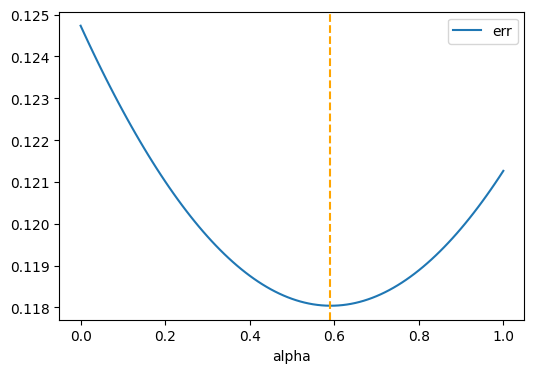

In [84]:
f, ax = plt.subplots(1, 1, figsize=(6, 4))

df_err = pandas.DataFrame(tmp).set_index(keys=["alpha"])

df_err.plot(ax=ax)
ax.axvline(x=df_err.sort_values(by=["err"]).index[0], ls='--', color='orange')

In [85]:
pandas.DataFrame(tmp).set_index(keys=["alpha"]).sort_values(by=["err"]).head(10)

,err
alpha,
0.59,0.118040
0.60,0.118041
0.58,0.118043
0.61,0.118047
0.57,0.118049
0.62,0.118056
0.56,0.118060
0.63,0.118069
0.55,0.118074
